In [1]:
"""
intersect regions, shuffled x TE

evaluate enrichment of TE per activity v. shuffled intersections
"""

'\nintersect regions, shuffled x TE\n\nevaluate enrichment of TE per activity v. shuffled intersections\n'

In [2]:
import configparser
import datetime
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import subprocess
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")

import config_readwrite as crw
import fet

# get plotting scripts

In [3]:
import plot_params as pp

pp.fonts()  # load font parameters
summary_labels = pp.summary_labels()  # get categorical labels for activity codes

# load config 

In [4]:
name = os.path.join("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/", "config")
config, config_name_ = crw.read_config(name)

# TE data
FILE = config["REPEATMASKER"]["te_data_hg38"]
BIN =config['REPEATMASKER']["BIN"] # script to intersect regions w TE
PATH = config["REPEATMASKER"]["path"]

ANNOT =config["CIS_TRANS"]["regions_annotations"] ## human shared accessibility regions
REGIONS =config["CIS_TRANS"]["regions"]
SHUFFLE = config["SHUFFLES"]["shuf-all"]

RE = config["REPEATMASKER"]["results"]
REGIONS_X_TE = config["REPEATMASKER"]["hh_regions_x_te"]  # write
REGIONS_X_TE_OR = config["REPEATMASKER"]["hh_regions_OR"]  # write

# functions

## intersect regions x TE

In [5]:
"""
intersect regions w/ te
"""

def te_intersect(bin_, bed, genome_build, outdir):
    cmd = f"python {bin_} {bed} {genome_build} {outdir}"
    print(cmd)
    subprocess.call(cmd, shell=True)

## add TE -bool col

In [6]:
"""
Add TE overlap - boolean column
"""
def add_te_binary_col(df):
    df["te_bin"] = False
    df.loc[df["te_count-hg38"] >0, "te_bin"] = True
    
    return df

## plotting bar charts

In [28]:
"""
plotting OR bar charts
"""
def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, order):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            linewidth=2.5, 
            order = order,
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero

    ax.set_xlabel("")


    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio, log2-scaled",  # y label
        title = title,
        ylim=ylim)
    return fig, ax

def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

## compute fraction overlap 

In [29]:
def computeFracExpectation(df, size, col, cutoff):
    """
    compute expected fraction of overlap
    
    input
        df (pd dataframe): dataframe with 
            ONLY expectation sequences and 
            the annotation that needs to be assess. 
        size (int): size of the dataset to pick at random
        col (str): column to assess for overlap
        cutoff (int): vavlue that measures expected column, count
    """
    
    exp_list = [] 
    # com
    for i in range(10000):
        # sample random shuffled sets, size of active_category elements, with replacement
        random_shuf_set = df.sample(n=size, replace=True)
        
        # get N elements < acceleration cutoff, N >= cutoff. 
        if random_shuf_set[col].dtype == bool:
            c = random_shuf_set.loc[random_shuf_set[col]==True].shape[0]
            d = random_shuf_set.loc[random_shuf_set[col]==False].shape[0]
            
        elif random_shuf_set[col].dtype == float:
            c = random_shuf_set.loc[random_shuf_set[col]<cutoff].shape[0]
            d = random_shuf_set.loc[random_shuf_set[col]>=cutoff].shape[0]
        
        # compute fraction accelerated
        random_exp = c/(c+d)
        
        # append to list
        exp_list.append(random_exp)
    return exp_list

## calculate empirical

In [9]:
def calculateEmpiricalP(obs, exp_sum_list):
    """
    return two lists
        (1) info - vector w/  
                n_obs, 
                median_exp, 
                std, 
                fold-change  # calculated from the median of expected shuffle 
                p_val
                
        (2) fold_changes- vector expected fold changes (to calculate confidence interval)
        
    input
        observed overlap count (int)
        list of expected overlap counts (list of ints)
    
    method
        1. get median of expected overlap counts
        2. get standard deviation of expected overlap counts
        3. center expected overlap counts at median
        4. Sum the number of centered expected counts greater than observed centered count
            This is two tailed because it evaluates both sides of the distribution (w/ abs value). 
        5. calculate fold change as observed/ median expected w/ pseudo count
        6. calculate fold change of each "obs"/ expected w/ pseudo count
        7. calculate the p-value as count of equal or more extreme values than observed value
        8. return list of empirical info + fold changes
        
        
    
    """
    #1 median of exp distribution
    mu = np.median(exp_sum_list)  
    
    #2 std
    sigma = np.std(exp_sum_list)  
    
    #3 center at median of distribution 
    dist_from_mu = [exp - mu for exp in exp_sum_list]  
    
    #4 # count values >= centered obs
    p_sum = sum(1 for exp_dist in dist_from_mu if abs(exp_dist) >= abs(obs - mu)) 

    #5 fold change obs from median expected w pseudo count
    fold_change = (obs + 1.0) / (mu + 1.0) 
    
    #6 fold change obs from /each exp w pseudo count
    fold_changes = list((obs + 1.0) / (m + 1.0) for m in exp_sum_list) 
    
    #7 probability of observing obs-like value 
    # equal or more extreme in expected distribution
    p_val = (p_sum + 1.0) / (len(exp_sum_list) + 1.0)  
    
    #8
    info = [
            obs, 
            mu, 
            sigma, 
            fold_change, 
            p_val, 
            str(datetime.datetime.now())
            ]
    
    #return info, fold_changes
    return p_val

# intersect regions, shuffles x TE

In [22]:
# intersect
GENOME_BUILD="hg38"

if os.path.exists(FILE) is False:
    # regions
    te_intersect(BIN, REGIONS, GENOME_BUILD, PATH)

    # shuffles
    te_intersect(BIN, SHUFFLE, GENOME_BUILD, PATH)

# import region x TE intersection

In [11]:
df_ = pd.read_csv(FILE, sep = '\t')  # 3665778 TABLE, # TABLE MERGED3971065
print(df_.shape)
df_ = add_te_binary_col(df_)
df_["shuf"] = False
df_.head()

(16897, 7)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf
0,chr1,959034,959154,chr1:959034-959154,0,['.'],['.'],False,False
1,chr1,1002089,1002179,chr1:1002089-1002179,0,['.'],['.'],False,False
2,chr1,1064140,1064260,chr1:1064140-1064260,1,['(CCTGG)n'],['Simple_repeat'],True,False
3,chr1,1214948,1215208,chr1:1214948-1215208,1,['MLT1B'],['LTR/ERVL-MaLR'],True,False
4,chr1,1215328,1215508,chr1:1215328-1215508,0,['.'],['.'],False,False


In [12]:
if df_["te_bin"].dtype == bool:
    print("bool")
else:
    print("no bool")

bool


## import region annotations

In [13]:
table = pd.read_csv(ANNOT, sep = '\t')  # 3665778 TABLE, # TABLE MERGED3971065
print(table.shape)
table.head()

(16897, 26)


,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# load shuffles

In [14]:
shuf_dict = {}
shufs = glob.glob(os.path.join(PATH, "shuf-all_uniq_diffAct_regions2-*_TE-cleaned.bed"))
for i, shuf in enumerate(shufs):
    shuf_df = pd.read_csv(shuf, sep = '\t')
    shuf_df= add_te_binary_col(shuf_df)
    shuf_df["shuf"] = True
    shuf_dict[i] = shuf_df
shufs = pd.concat(shuf_dict.values())

print(shufs.shape)
shufs.head()

(168970, 9)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf
0,chr1,941280,941390,chr20:57619015-57619125,0,['.'],['.'],False,True
1,chr1,941296,941726,chr16:10842984-10843414,0,['.'],['.'],False,True
2,chr1,941421,941761,chr15:67254382-67254722,0,['.'],['.'],False,True
3,chr1,941486,941676,chr3:122074869-122075059,0,['.'],['.'],False,True
4,chr1,941502,941732,chr6:2857253-2857483,0,['.'],['.'],False,True


# how many regions overlap N TEs?

te_bin

False    12790 (76%)

True      4107 (24%)

In [15]:
df_.groupby("te_bin")["region_id"].count(), df_.groupby("te_bin")["region_id"].count()/df_.shape[0]

(te_bin
 False    12790
 True      4107
 Name: region_id, dtype: int64,
 te_bin
 False    0.756939
 True     0.243061
 Name: region_id, dtype: float64)

# merge TE and table data together 
- inner join so that only shared acc peaks are included
- reassign cis.regions/trans.regions label to distinguish from cis+trans downstream

In [16]:
df = pd.merge(df_, table)

print(df.shape)
df.loc[df["cis+trans"] ==1, ["cis.regions", "trans.regions"]] =0 # edit this col
df.head()

(16897, 31)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf,conserved_active.regions,...,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,cis.regions,trans.regions
0,chr1,959034,959154,chr1:959034-959154,0,['.'],['.'],False,False,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0,['.'],['.'],False,False,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,1,['(CCTGG)n'],['Simple_repeat'],True,False,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,chr1,1214948,1215208,chr1:1214948-1215208,1,['MLT1B'],['LTR/ERVL-MaLR'],True,False,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0,['.'],['.'],False,False,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN


# among human active sequences, are some divergent categories more enriched than others for TE overlap?

## COMPUTE HERE!! compute fraction of overlap

In [17]:
def plotEmpiricalDist(exp_dist, obs, title, xlabel, re, sample_name, p):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.histplot(exp_dist)
    ax.set(
          title=title,
          xlabel=xlabel,
    )
    ax.axvline(obs, c = "k")
    ax.text(obs, 10, f"emp. p={p}")
    
    out = os.path.join(RE, sample_name + f"empdist.frac.pdf" )
    plt.savefig(out, bbox_inches="tight")
    plt.show()

In [18]:
col_set = [ 'cis+trans',
            'conserved_active.regions',
            'trans_only',
            'cis_only',
            ]


"""
 other col sets
 ['conserved_active.regions','HH-active_MM-inactive_trans-only',
 'HH-active_MM-inactive_cis-only',
 'HH-active_MM-inactive_cis+trans'],
 ['conserved_active.regions',
  'MM-active_HH-inactive_cis-only',
 'MM-active_HH-inactive_trans-only',
 'MM-active_HH-inactive_cis+trans']
"""

"\n other col sets\n ['conserved_active.regions','HH-active_MM-inactive_trans-only',\n 'HH-active_MM-inactive_cis-only',\n 'HH-active_MM-inactive_cis+trans'],\n ['conserved_active.regions',\n  'MM-active_HH-inactive_cis-only',\n 'MM-active_HH-inactive_trans-only',\n 'MM-active_HH-inactive_cis+trans']\n"

In [19]:
def getColIds(df, col):
    ids = set(df.loc[df[col]==1, "region_id"])
    
    return ids

In [30]:
"""
Test fraction of cis | trans | cis+trans elements (i.e. in col) that overlap TE v 
fraction of boostrapped background (i.e. not in col) of elements for TE overlap
"""

cat_results = {}
data = df.copy()
for in_col in col_set:

    out_cols = col_set[::]  # copy the list so that you don't destroy original list
    out_cols.remove(in_col) # remove the column to test from the other columns
    print(in_col, out_cols)

    # get the list of region ids in the in_col set
    test_ids = getColIds(data, in_col)
    test= data.loc[data["region_id"].isin(test_ids), ["region_id", "te_bin"]]
    
    a = test.loc[(test["te_bin"]== True)].shape[0]
    b = test.loc[(test["te_bin"]== False)].shape[0]
    
    obs = a/(a+b)
    
    # get the counts of TE overlaps (c) and non-overlaps (d) in bkgd columns
    
    # get the background columns as the regions in the out col set
    bkgd_ids = set()
    for i in out_cols:
        b_ids = getColIds(data, i)
        bkgd_ids.update(b_ids)
    
    bkgd = data.loc[data["region_id"].isin(bkgd_ids), ["region_id", "te_bin"]].drop_duplicates()
    size = bkgd["region_id"].drop_duplicates().shape[0]
    cutoff = None


    exp_list = computeFracExpectation(bkgd, size, "te_bin", cutoff)
    cat_results[in_col] = (obs, exp_list)
    print(obs, np.median(exp_list))


cis+trans ['conserved_active.regions', 'trans_only', 'cis_only']
0.26121739130434785 0.22437595872263283
conserved_active.regions ['cis+trans', 'trans_only', 'cis_only']
0.2257745550428477 0.24902052969753957
trans_only ['cis+trans', 'conserved_active.regions', 'cis_only']
0.21936459909228442 0.24809961630348223
cis_only ['cis+trans', 'conserved_active.regions', 'trans_only']
0.22748375116063138 0.24725113619703856


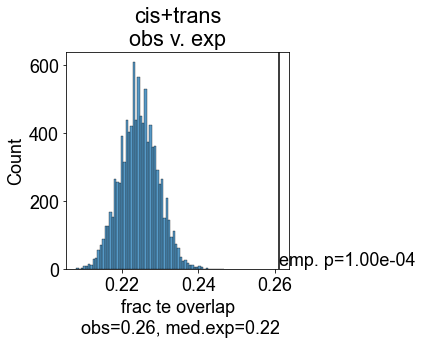

obs 0.26 median expected 0.22


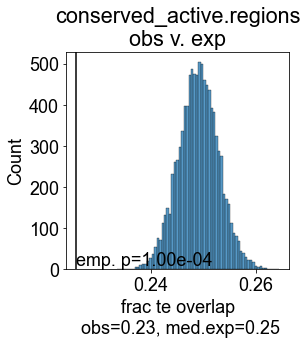

obs 0.23 median expected 0.25


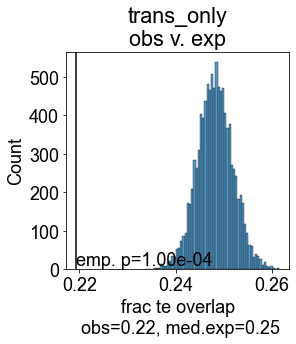

obs 0.22 median expected 0.25


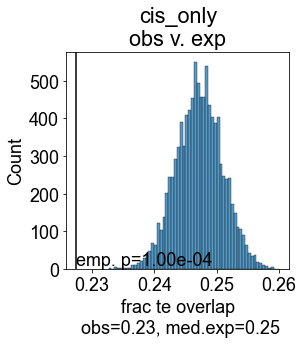

obs 0.23 median expected 0.25


In [32]:
for col, values in cat_results.items():
    
    obs, exp_list = values
    
    empiricalp = calculateEmpiricalP(obs, exp_list)
    title = f"{col}\nobs v. exp"
    xlabel = f"frac te overlap\n obs={round(obs,2)}, med.exp={round(np.median(exp_list),2)}"
    re = RE
    sample_name = col
    plotEmpiricalDist(exp_list, obs, title, xlabel, re, sample_name, "{:.2e}".format(empiricalp))
    print("obs", round(obs,2), "median expected", round(np.median(exp_list),2))

In [1]:
RE

NameError: name 'RE' is not defined

## OR activity category v. all other active

In [33]:
"""
2x2 set up 

"cis_only", "trans_only", "cons_act", "cis+trans"

Hypothesis - cis_only is enriched for TEs compared to all other categories. 

                TE - True    TE - False
cis_only - True    A      |    B
cis_only - False   C      |    D

"""

cat_results = {}
data = df
for in_col in col_set:

    out_cols = col_set[::]  # copy the list so that you don't destroy original list
    out_cols.remove(in_col) # remove the column to test from the other columns
    print(in_col, out_cols)
    test_ids = getColIds(data, in_col)
    test= data.loc[data["region_id"].isin(test_ids), ["region_id", "te_bin"]]

    a = test.loc[(test["te_bin"]== True)].shape[0]
    b = test.loc[(test["te_bin"]== False)].shape[0]

    bkgd_ids = set()
    for i in out_cols:
        b_ids = getColIds(data, i)
        bkgd_ids.update(b_ids)
    
    bkgd = data.loc[data["region_id"].isin(bkgd_ids), ["region_id", "te_bin"]].drop_duplicates()
    c = bkgd.loc[(bkgd["te_bin"]== True)].shape[0]
    d = bkgd.loc[(bkgd["te_bin"]== False)].shape[0]
    print([[a,b],[c,d]])

    fet_results = fet.get_2x2(a,b,c,d, f"{in_col}-activity_x_te")
    fet_results["col"] = in_col
    cat_results[in_col] = fet_results


fdr_fet = fet.fdr_correction(cat_results)  # do FDR correction
fdr_fet["frac"] = fdr_fet["a"]/ (fdr_fet["a"]+ fdr_fet["b"])

cis+trans ['conserved_active.regions', 'trans_only', 'cis_only']
[[2253, 6372], [1610, 5561]]
[[2253, 6372], [1610, 5561]]
cis+trans-activity_x_te [[2253, 6372], [1610, 5561]] 1.221272122211695 9.436160427963146e-08
conserved_active.regions ['cis+trans', 'trans_only', 'cis_only']
[[685, 2349], [3178, 9584]]
[[685, 2349], [3178, 9584]]
conserved_active.regions-activity_x_te [[685, 2349], [3178, 9584]] 0.8794283603134684 0.007389452799802706
trans_only ['cis+trans', 'conserved_active.regions', 'cis_only']
[[435, 1548], [3428, 10385]]
[[435, 1548], [3428, 10385]]
trans_only-activity_x_te [[435, 1548], [3428, 10385]] 0.8513026557397809 0.005202069058035235
cis_only ['cis+trans', 'conserved_active.regions', 'trans_only']
[[490, 1664], [3373, 10269]]
[[490, 1664], [3373, 10269]]
cis_only-activity_x_te [[490, 1664], [3373, 10269]] 0.8965088285935825 0.04894301171103044


In [34]:
fdr_fet

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,col,reject_null,FDR_P,asterisks,-log10p,frac
0,2253,6372,1610,5561,1.221272,9.436160e-08,1.134864,0.105866,1.314260,0.105866,0.288385,0.182519,0.394250,cis+trans-activity_x_te,cis+trans,True,3.774464e-07,*,6.423145,0.261217
0,685,2349,3178,9584,0.879428,7.389453e-03,0.800456,0.135743,0.966191,0.135743,-0.185362,-0.321105,-0.049619,conserved_active.regions-activity_x_te,conserved_active.regions,True,9.852604e-03,*,2.006449,0.225775
0,435,1548,3428,10385,0.851303,5.202069e-03,0.760227,0.163242,0.953289,0.163242,-0.232256,-0.395498,-0.069014,trans_only-activity_x_te,trans_only,True,9.852604e-03,*,2.006449,0.219365
0,490,1664,3373,10269,0.896509,4.894301e-02,0.804741,0.155793,0.998741,0.155793,-0.157610,-0.313403,-0.001818,cis_only-activity_x_te,cis_only,True,4.894301e-02,*,1.310309,0.227484


In [27]:
# plot OR
for key in plot_sets.keys():
    order = plot_sets[key]
    x = "col"
    y = "OR_log2"
    data = fdr_fet.loc[fdr_fet['col'].isin(order)]
    ci_upper, ci_lower = "ci_upper_log2", "ci_lower_log2"
    ytick_multiple = 1
    ylim =(-1,1) # log2 coordinates

    title = f"TE enrichment\n{key} v. other active regions\n"
    hue = None

    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, order)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

    annotate_bar(ax, "x", list(data['a']), 0.05)
    annotate_bar(ax, "x", list(data["frac"].round(2).apply(lambda x: str(x*100).split(".")[0]+ "%")), 0.2)
    outf = os.path.join(RE, f"SharedACC_HH_isActive_TE_OR_Regions_vothers-{key}_v2.pdf")
    plt.savefig(outf, bbox_inches = "tight")

NameError: name 'plot_sets' is not defined

2x2


                    TE True      TE False


    Category True     A.           B


    Category False    C.           D

# TE family enrichment in active category v. all other active categories


- TE must overlap at least 50 regions to be considered. 

In [ ]:
def test_te_enrichment(col, t, df):
    ###
    #DEV
    ###
    #                     TE overlap -True    TE overlap -False

    # cis.regions -True    A                          B  
    # cis.regions -Flase   C                          D

    """
    1. for single te, for single test regulatory category
    2. get all the regions that overlap that TE. 
    3. get all regions in test category
    4. get all regions not in category and subtract any regions that overlap the test category
    5. count test category regions overlapping TE
    6. count all test category regions NOT overlapping TE
    7. count NOT test category regions overlapping TE
    8. count NOT test category regions NOT overlapping TE
    9. if there are at least 50 TE instances in dataset, calculate FET enrichment

    """
    #t = "Alu"
    #col = "cis+trans"

    #1
    test = df.loc[df["shuf"]==False]

    #2
    TE_true_regions = set(test.loc[(test["te"].str.contains(t)), "region_id"])  # get all the regions w/ TE

    blank = pd.DataFrame({col:[True, False]})

    #3
    col_true_regions = set(test.loc[test[col] ==1, "region_id"])

    #4
    col_false_regions = set(test.loc[test[col] ==0, "region_id"])
    col_false_regions = col_false_regions.difference(col_true_regions)

    #5
    a = len(TE_true_regions.intersection(col_true_regions))
    #6
    b = len(col_true_regions.difference(TE_true_regions))
    #7
    c = len(TE_true_regions.intersection(col_false_regions))
    #8
    d = len(col_false_regions.difference(TE_true_regions))
    #print(a,b, c,d)

    if a + c >50:
        comparison = f"{col}_x_{t}"
        #5
        fet_results = fet.get_2x2(a,b,c,d, comparison)
        fet_results["te"] = t
        fet_results["activity_cat"] = col
        
    else:
        fet_results = pd.DataFrame()
    
    return fet_results

## make a list of TEs to test

In [ ]:
tested_tes = []
for te in df.te.unique():
    for t in te.split(" "):
        if t not in tested_tes:
            t_ = str(t.strip("[]")).strip("''")
            tested_tes.append(t_)


tested_tes[1]

## unit test for one TE enrichment. 

In [ ]:
###
#DEV
###
#                     TE overlap -True    TE overlap -False

# cis.regions -True    A                          B  
# cis.regions -Flase   C                          D

"""
1. for single te, for single test regulatory category
2. get all the regions that overlap that TE. 
3. get all regions in test category
4. get all regions not in category and subtract any regions that overlap the test category
5. count test category regions overlapping TE
6. count all test category regions NOT overlapping TE
7. count NOT test category regions overlapping TE
8. count NOT test category regions NOT overlapping TE
9. if there are at least 50 TE instances in dataset, calculate FET enrichment

"""
t = "Alu"
col = "cis+trans"
#col = "cis.regions"

comparison = f"{t}_x_{col}"
#1
test = df.loc[df["shuf"]==False]

#2
TE_true_regions = set(test.loc[(test["te"].str.contains(t)), "region_id"])  # get all the regions w/ TE

blank = pd.DataFrame({col:[True, False]})

#3
col_true_regions = set(test.loc[test[col] ==1, "region_id"])

#4
col_false_regions = set(test.loc[test[col] ==0, "region_id"])
col_false_regions = col_false_regions.difference(col_true_regions)

#5
a = len(TE_true_regions.intersection(col_true_regions))
#6
b = len(col_true_regions.difference(TE_true_regions))
#7
c = len(TE_true_regions.intersection(col_false_regions))
#8
d = len(col_false_regions.difference(TE_true_regions))
print(a,b, c,d)

if a + c >50:
    #5
    fet_results = fet.get_2x2(a,b,c,d, comparison)
    fet_results["te"] = t
    fet_results["activity_cat"] = col

In [ ]:
cols = [
        "conserved_active.regions", 
    'trans_only',
    'cis_only',     
    "cis+trans",
    'HH-active_MM-inactive_trans-only',
    'HH-active_MM-inactive_cis-only',
    'HH-active_MM-inactive_cis+trans',
    'MM-active_HH-inactive_cis-only',
    'MM-active_HH-inactive_trans-only',
    'MM-active_HH-inactive_cis+trans',

]

"""
#                     TE overlap -True    TE overlap -False

# cis.regions -True    A                          B  
# cis.regions -Flase   C                          D


1. for single te, for single test regulatory category
2. get all the regions that overlap that TE. 
3. get all regions in test category
4. get all regions not in category and subtract any regions that overlap the test category
5. count test category regions overlapping TE
6. count all test category regions NOT overlapping TE
7. count NOT test category regions overlapping TE
8. count NOT test category regions NOT overlapping TE
9. if there are at least 50 TE instances in dataset, calculate FET enrichment
10. add to dictionary. 
11. FDR correct per test category (e.g. trans only)

"""
outf = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/repeatmasker/HH_activity_code_OR_all_regions_v2.tsv"
#if os.path.exists(outf) is False:
col_results = {}
for col in cols:
    print(col)

    blank = pd.DataFrame({col:[True, False]})
    te_col = {}

    if col not in col_results.keys():

        for t in set(tested_tes[1:]):
            results = test_te_enrichment(col, t, df)

            if True in set(results.any()):
                te_col[t] = results
                #print(type(results), cols)
            else:
                continue

    #11
    fdr_results = fet.fdr_correction(te_col)
    col_results[col] = fdr_results

all_te_enrichment = pd.concat(col_results.values())

all_te_enrichment.to_csv(outf, sep = '\t', index = False)
#else:
#   all_te_enrichment = pd.read_csv(outf, sep = '\t')

In [ ]:
for_plotting = ['cis+trans','trans_only', 'cis_only', 'conserved_active.regions', 
               #'HH-active_MM-inactive_cis+trans', 'MM-active_HH-inactive_cis+trans'
               ]

In [ ]:
split_at = round(len(col_results.keys())/2, 0)
split_at = round(len(for_plotting)/2, 0)
fig, ax_ = plt.subplots(ncols = 2, nrows = int(split_at), figsize = (14,14))
idxcol, idxrow = 0,0

for key, val in col_results.items():
    if key in for_plotting:

        print(idxrow, idxcol)
        ax = ax_[idxrow][idxcol]
        val['-log10p'] = np.log10(val["FDR_P"])*-1

        x = "OR_log2"
        y = "-log10p"
        hue = "activity_cat"
        data = col_results[key]
        size = list(data["a"])

        #fig, ax = plt.subplots(figsize = (6,6))
        sns.scatterplot(x=x, y=y, data=data, hue=hue, ax=ax, size=size)
        ax.set(title = key)
        ax.axvline(0, ls = "--")

        sig = data.loc[(data[x].astype(float)>0) 
                       #& (data["reject_null"]==True)
                      ].sort_values(by=y, ascending=False)

        # Annotate sign TE label points 
        for i, l in enumerate(sig["te"]):
            print(i, l, sig[x].iloc[i])
            ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
            if i >10:
                break
        ax.legend(loc="upper left")#bbox_to_anchor = (1,1))#.remove()
        ax.set(title = key, xlim =(-4,4), 
               ylim=(-0.5,10)
              )
        ax.axvline(0, ls = "--")

        idxrow +=1

        if idxrow ==split_at:
            idxrow = 0
            idxcol = 1

        del data, sig

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_regions_all_v2.pdf")
plt.savefig(outf, bbox_inches = "tight")

In [ ]:
data = col_results["cis+trans"]
sig = data.loc[(data[x].astype(float)>0)]
sig.sort_values(by=y, ascending=False)

In [ ]:
for_plotting = ['HH-active_MM-inactive_cis+trans',
                'HH-active_MM-inactive_trans-only',
                'HH-active_MM-inactive_cis-only',                
                'MM-active_HH-inactive_cis+trans',
                'MM-active_HH-inactive_trans-only',
                'MM-active_HH-inactive_cis-only',
                ]

# scatterplot for HH, MM

In [ ]:
split_at = round(len(col_results.keys())/2, 0)
split_at = round(len(for_plotting)/2, 0)
fig, ax_ = plt.subplots(ncols = 2, nrows = int(split_at), figsize = (14,22))
idxcol, idxrow = 0,0

#for key, val in col_results.items():
for key in for_plotting:

    print(idxrow, idxcol)
    ax = ax_[idxrow][idxcol]
    val['-log10p'] = np.log10(val["FDR_P"])*-1

    x = "OR_log2"
    y = "-log10p"
    hue = "activity_cat"
    data = col_results[key]
    size = "a"

    #fig, ax = plt.subplots(figsize = (6,6))
    sns.scatterplot(x=x, y=y, data=data, hue=hue, ax=ax, size=size)
    ax.set(title = key)
    ax.axvline(0, ls = "--")
    
    sig = data.loc[(data[x].astype(float)>0) & (data["reject_null"]==True)]

    # Annotate sign TE label points 
    for i, l in enumerate(sig["te"]):
        print(i, l, sig[x].iloc[i])
        ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
    ax.legend(bbox_to_anchor = (1,1)).remove()
    ax.set(title = key, xlim =(-4,4), 
           ylim=(-0.5,10)
          )
    ax.axvline(0, ls = "--")
    
    idxrow +=1

    if idxrow ==split_at:
        idxrow = 0
        idxcol = 1

    del data, sig
    
outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_regions_HH_v_MM_v2.pdf")
plt.savefig(outf, bbox_inches = "tight")

# save dataframe 

In [ ]:
all_te_enrichment = pd.concat(col_results.values())

all_te_enrichment.head()

In [ ]:
outf = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/repeatmasker/TE_activity_code_OR_all_regions_v2.tsv"
all_te_enrichment.to_csv(outf, sep = '\t', index = False)

# plot all categories together. 

In [ ]:
all_te_enrichment['-log10p'] = np.log10(all_te_enrichment["FDR_P"])*-1

x = "OR_log2"
y = "-log10p"
hue = "activity_cat"

data = all_te_enrichment.loc[all_te_enrichment["reject_null"]==True]
size = list(data["a"])

fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(x=x, y=y, data=data, hue=hue, s=size)
ax.set(title = key, xlim=(-3,3))
ax.axvline(0, ls = "--")

sig = data.loc[(data[x].astype(float)>0)]

# Annotate label points 
for i, l in enumerate(sig["te"]):
    #print(i, l, data[x].iloc[i])
    ax.annotate(l, (sig[x].iloc[i]+0.2, sig[y].iloc[i]+0.2) )

ax.legend(bbox_to_anchor = (1,1))

ax.set(title = "Sig TE Enrichment\nSharedAcc HH_is_active regions\n",
      ylabel = "-log10(FDR p-value)")

ax.axvline(0, ls = "--")

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_ALL_regions_20220411.pdf")
#plt.savefig(outf, bbox_inches = "tight")

plt.show()

# plot N

In [ ]:
all_te_enrichment["te"].unique()

In [ ]:
all_te_enrichment

In [ ]:
all_te_enrichment["frac"] = all_te_enrichment["a"]/(all_te_enrichment["a"] + all_te_enrichment["b"]) 
all_te_enrichment

In [ ]:
##### 

x="frac"
y="te"
hue = "activity_cat"
data = all_te_enrichment
fig, (ax1, ax2) = plt.subplots( ncols = 2, figsize = (12,12))
sns.barplot(x=x, y=y, data=data, hue=hue, ax = ax1)
ax1.legend(bbox_to_anchor = (1,1)).remove()
ax1.set(xlabel = "frac regions w TE")

#ax2 = ax1.twiny()
x="a"
sns.barplot(x=x, y=y, data=data, hue=hue, ax = ax2)
ax2.legend(bbox_to_anchor = (1,1))
ax2.set(xlabel = "N regions w TE\n")

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_20220411.pdf")
#plt.savefig(outf, bbox_inches = "tight")